# Backtest on the portfolio based on chapter 3 of Vorobets (2025)


In [4]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [6]:
SELECTED_ASSETS = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
BENCHMARK = '^GSPC'

TARGET_WEIGHTS = np.array([
    0.0413, 0.0516, 0.0414, 0.0597, 0.1624, 0.0901,
    0.0240, 0.0992, 0.0790, 0.0707, 0.0519, 0.2286
])

REBAL_FREQ = 63  
RF_RATE = 0.04   

# Historical Backtest (Full Sample)

In [7]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

all_assets = SELECTED_ASSETS + [BENCHMARK]
existing_assets = [c for c in all_assets if c in data.columns]
data = data[existing_assets]
data = data[data > 0].dropna()

pnl = np.log(data / data.shift(1)).dropna()
asset_returns = pnl[SELECTED_ASSETS]
benchmark_returns = pnl[BENCHMARK]

print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")

Returns: 2470 days × 13 assets
Date range: 2016-01-05 → 2025-11-11


In [8]:
def run_backtest(asset_ret, bench_ret, target_w, rebal_freq, drift_weights=True):
    """
    Run backtest with optional weight drift.
    
    Parameters
    ----------
    asset_ret : np.ndarray, shape (T, I)
    bench_ret : np.ndarray, shape (T,)
    target_w : np.ndarray, shape (I,)
    rebal_freq : int
    drift_weights : bool
        If True, weights drift between rebalances. If False, constant weights.
    
    Returns
    -------
    portfolio_value, benchmark_value, portfolio_returns, rebal_indices
    """
    T = len(asset_ret)
    portfolio_value = np.ones(T + 1)
    benchmark_value = np.ones(T + 1)
    portfolio_returns = np.zeros(T)
    rebal_indices = []
    
    weights = target_w.copy()
    
    for t in range(T):
        daily_ret = asset_ret[t]
        port_ret = np.sum(weights * daily_ret)
        portfolio_returns[t] = port_ret
        
        portfolio_value[t + 1] = portfolio_value[t] * np.exp(port_ret)
        benchmark_value[t + 1] = benchmark_value[t] * np.exp(bench_ret[t])
        
        if drift_weights:
            weights = weights * np.exp(daily_ret)
            weights = weights / weights.sum()
        
        if (t + 1) % rebal_freq == 0:
            weights = target_w.copy()
            rebal_indices.append(t)
    
    return portfolio_value, benchmark_value, portfolio_returns, rebal_indices

In [9]:
port_val, bench_val, port_rets, rebal_idx = run_backtest(
    asset_returns.values, 
    benchmark_returns.values, 
    TARGET_WEIGHTS, 
    REBAL_FREQ,
    drift_weights=True
)

dates = [pnl.index[0]] + list(asset_returns.index)
results = pd.DataFrame({'Portfolio': port_val, 'Benchmark': bench_val}, index=dates)
rebal_dates = [asset_returns.index[i] for i in rebal_idx]

In [10]:
def compute_metrics(values, daily_returns, years, rf_rate=0.0):
    """
    Compute performance metrics from actual portfolio returns.
    """
    cagr = (values[-1] ** (1 / years) - 1)
    vol = np.std(daily_returns) * np.sqrt(252)
    sharpe = (cagr - rf_rate) / vol if vol > 0 else 0.0
    
    cummax = np.maximum.accumulate(values)
    drawdown = (values - cummax) / cummax
    max_dd = drawdown.min()
    
    return {'cagr': cagr, 'vol': vol, 'sharpe': sharpe, 'max_dd': max_dd}

In [11]:
total_days = len(results) - 1
years = total_days / 252

port_metrics = compute_metrics(port_val, port_rets, years, RF_RATE)
bench_rets = benchmark_returns.values
bench_metrics = compute_metrics(bench_val, bench_rets, years, RF_RATE)

print(f"{'='*55}")
print(f"BACKTEST RESULTS ({years:.1f} years)")
print(f"{'='*55}")
print(f"{'Metric':<20} {'Portfolio':>12} {'Benchmark':>12}")
print(f"{'-'*55}")
print(f"{'CAGR':<20} {port_metrics['cagr']:>11.2%} {bench_metrics['cagr']:>11.2%}")
print(f"{'Volatility':<20} {port_metrics['vol']:>11.2%} {bench_metrics['vol']:>11.2%}")
print(f"{'Sharpe (rf={RF_RATE:.0%})':<20} {port_metrics['sharpe']:>12.2f} {bench_metrics['sharpe']:>12.2f}")
print(f"{'Max Drawdown':<20} {port_metrics['max_dd']:>11.2%} {bench_metrics['max_dd']:>11.2%}")
print(f"{'Final Value':<20} {port_val[-1]:>12.2f} {bench_val[-1]:>12.2f}")
print(f"{'Rebalancing events':<20} {len(rebal_dates):>12}")

BACKTEST RESULTS (9.8 years)
Metric                  Portfolio    Benchmark
-------------------------------------------------------
CAGR                      23.28%      13.30%
Volatility                16.64%      18.27%
Sharpe (rf={RF_RATE:.0%})         1.16         0.51
Max Drawdown             -26.56%     -33.92%
Final Value                  7.78         3.40
Rebalancing events             39


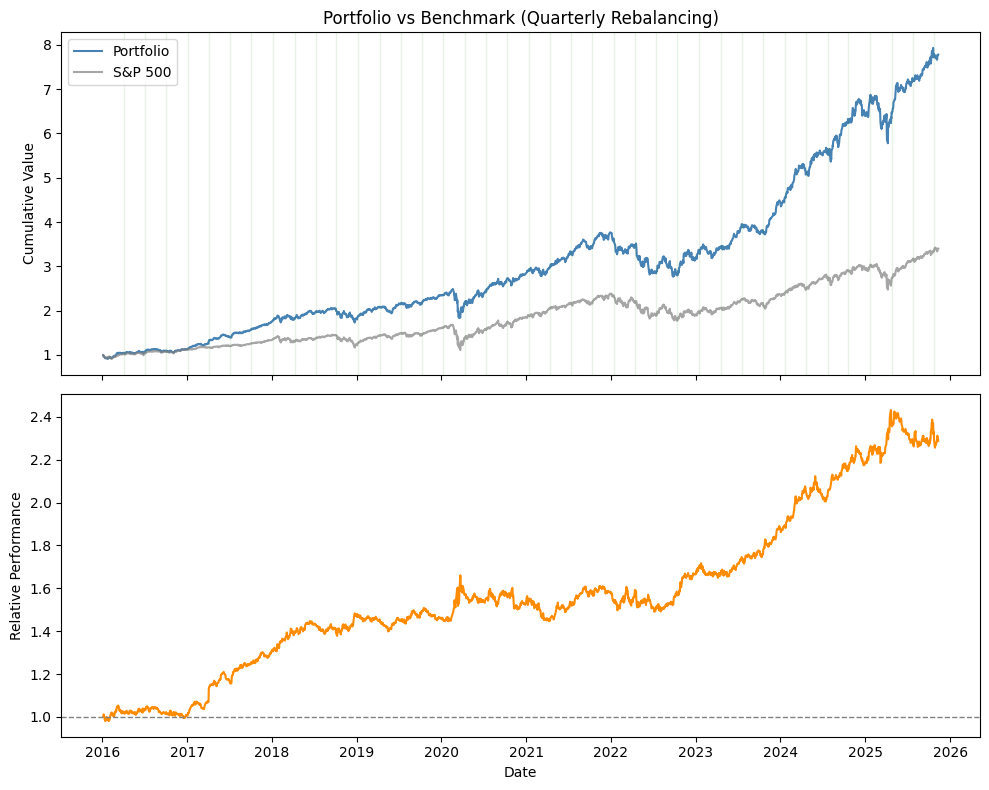

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(results.index, results['Portfolio'], label='Portfolio', color='steelblue')
axes[0].plot(results.index, results['Benchmark'], label='S&P 500', color='grey', alpha=0.7)
for rd in rebal_dates:
    axes[0].axvline(rd, color='green', alpha=0.1, lw=1)
axes[0].set_ylabel('Cumulative Value')
axes[0].legend()
axes[0].set_title('Portfolio vs Benchmark (Quarterly Rebalancing)')

axes[1].plot(results.index, results['Portfolio'] / results['Benchmark'], color='darkorange')
axes[1].axhline(1, color='grey', ls='--', lw=1)
axes[1].set_ylabel('Relative Performance')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Simulated Historical Paths (Out-of-Sample with Bootstrap)

In [13]:
H = REBAL_FREQ
S = 1000
OUT_OF_SAMPLE_YEARS = 5
BLOCK_SIZE = 21  
USE_BLOCK_BOOTSTRAP = True

out_of_sample_obs = OUT_OF_SAMPLE_YEARS * 252
out_of_sample_quarters = OUT_OF_SAMPLE_YEARS * 4

np.random.seed(42)

print(f"Horizon: {H} days per quarter")
print(f"Synthetic paths: {S}")
print(f"Out-of-sample: {OUT_OF_SAMPLE_YEARS} years ({out_of_sample_obs} days, {out_of_sample_quarters} quarters)")
print(f"Bootstrap: {'Block (size=' + str(BLOCK_SIZE) + ')' if USE_BLOCK_BOOTSTRAP else 'IID'}")

Horizon: 63 days per quarter
Synthetic paths: 1000
Out-of-sample: 5 years (1260 days, 20 quarters)
Bootstrap: Block (size=21)


In [14]:
def block_bootstrap_indices(T_in, n_samples, block_size):
    """
    Generate indices for block bootstrap resampling.
    Preserves local autocorrelation structure.
    """
    indices = []
    i = 0
    while i < n_samples:
        start = np.random.randint(0, T_in - block_size + 1)
        block_len = min(block_size, n_samples - i)
        indices.extend(range(start, start + block_len))
        i += block_len
    return np.array(indices[:n_samples])

def iid_bootstrap_indices(T_in, n_samples):
    return np.random.choice(T_in, size=n_samples, replace=True)

In [15]:
asset_ret_full = asset_returns.values
bench_ret_full = benchmark_returns.values
T_full = len(asset_ret_full)

portfolio_synth = np.ones((S, out_of_sample_obs + 1))
benchmark_synth = np.ones((S, out_of_sample_obs + 1))

oos_asset_ret = asset_ret_full[-out_of_sample_obs:]
oos_bench_ret = bench_ret_full[-out_of_sample_obs:]
oos_dates = pnl.index[-out_of_sample_obs:]

for q in range(out_of_sample_quarters):
    t_start = q * H
    t_end = min((q + 1) * H, out_of_sample_obs)
    quarter_len = t_end - t_start
    
    in_sample_end = T_full - out_of_sample_obs + t_start
    in_sample_asset = asset_ret_full[:in_sample_end]
    in_sample_bench = bench_ret_full[:in_sample_end]
    T_in = len(in_sample_asset)
    
    for s in range(S):
        if USE_BLOCK_BOOTSTRAP:
            sim_idx = block_bootstrap_indices(T_in, quarter_len, BLOCK_SIZE)
        else:
            sim_idx = iid_bootstrap_indices(T_in, quarter_len)
        
        sim_asset_ret = in_sample_asset[sim_idx]
        sim_bench_ret = in_sample_bench[sim_idx]
        
        weights = TARGET_WEIGHTS.copy()
        for h in range(quarter_len):
            t = t_start + h
            port_ret = np.sum(weights * sim_asset_ret[h])
            portfolio_synth[s, t + 1] = portfolio_synth[s, t] * np.exp(port_ret)
            benchmark_synth[s, t + 1] = benchmark_synth[s, t] * np.exp(sim_bench_ret[h])
            
            weights = weights * np.exp(sim_asset_ret[h])
            weights = weights / weights.sum()

port_realized, bench_realized, port_rets_oos, _ = run_backtest(
    oos_asset_ret, oos_bench_ret, TARGET_WEIGHTS, REBAL_FREQ, drift_weights=True
)

print(f"Simulation complete: {out_of_sample_quarters} quarters, {S} synthetic paths")

Simulation complete: 20 quarters, 1000 synthetic paths


In [16]:
years_oos = out_of_sample_obs / 252

port_metrics_oos = compute_metrics(port_realized, port_rets_oos, years_oos, RF_RATE)
bench_rets_oos = oos_bench_ret
bench_metrics_oos = compute_metrics(bench_realized, bench_rets_oos, years_oos, RF_RATE)

synth_final = portfolio_synth[:, -1]
synth_median = np.median(synth_final)
synth_5th = np.percentile(synth_final, 5)
synth_95th = np.percentile(synth_final, 95)

print(f"{'='*55}")
print(f"OUT-OF-SAMPLE PERFORMANCE ({years_oos:.1f} years)")
print(f"{'='*55}")
print(f"{'Metric':<20} {'Portfolio':>12} {'Benchmark':>12}")
print(f"{'-'*55}")
print(f"{'CAGR':<20} {port_metrics_oos['cagr']:>11.2%} {bench_metrics_oos['cagr']:>11.2%}")
print(f"{'Volatility':<20} {port_metrics_oos['vol']:>11.2%} {bench_metrics_oos['vol']:>11.2%}")
print(f"{'Sharpe (rf={RF_RATE:.0%})':<20} {port_metrics_oos['sharpe']:>12.2f} {bench_metrics_oos['sharpe']:>12.2f}")
print(f"{'Max Drawdown':<20} {port_metrics_oos['max_dd']:>11.2%} {bench_metrics_oos['max_dd']:>11.2%}")
print(f"{'Final Value':<20} {port_realized[-1]:>12.2f} {bench_realized[-1]:>12.2f}")
print(f"{'-'*55}")
print(f"{'SYNTHETIC PATHS':^55}")
print(f"{'-'*55}")
print(f"{'Median Final':<20} {synth_median:>12.2f}")
print(f"{'5th Percentile':<20} {synth_5th:>12.2f}")
print(f"{'95th Percentile':<20} {synth_95th:>12.2f}")
print(f"{'Realized Percentile':<20} {(synth_final < port_realized[-1]).mean():>11.1%}")

OUT-OF-SAMPLE PERFORMANCE (5.0 years)
Metric                  Portfolio    Benchmark
-------------------------------------------------------
CAGR                      24.58%      15.92%
Volatility                16.52%      16.99%
Sharpe (rf={RF_RATE:.0%})         1.25         0.70
Max Drawdown             -26.42%     -25.43%
Final Value                  3.00         2.09
-------------------------------------------------------
                    SYNTHETIC PATHS                    
-------------------------------------------------------
Median Final                 2.74
5th Percentile               1.50
95th Percentile              5.00
Realized Percentile        58.8%


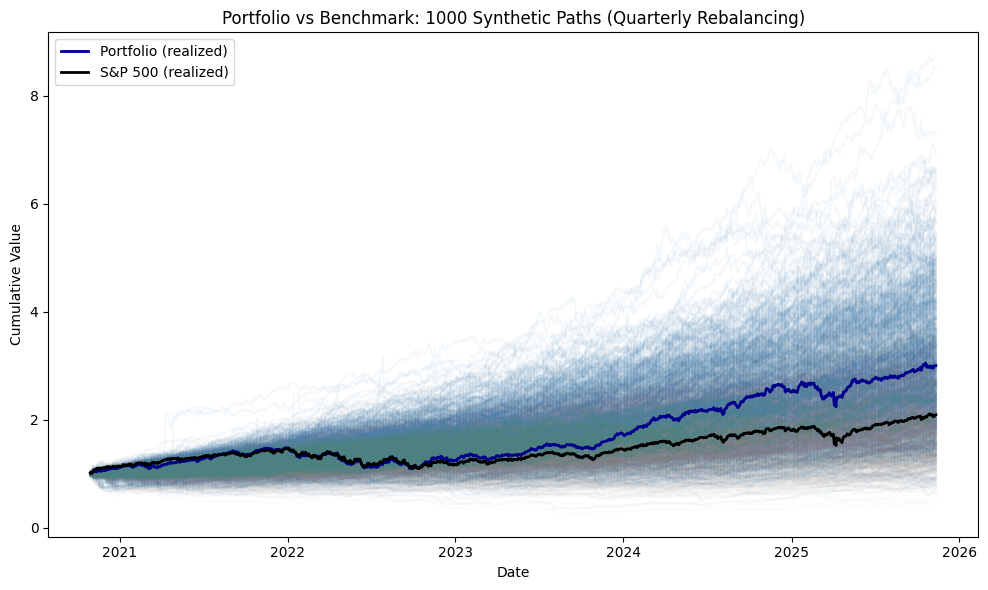

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(oos_dates, portfolio_synth[:, 1:].T, color='steelblue', alpha=0.05)
ax.plot(oos_dates, benchmark_synth[:, 1:].T, color='grey', alpha=0.02)
ax.plot(oos_dates, port_realized[1:], color='darkblue', lw=2, label='Portfolio (realized)')
ax.plot(oos_dates, bench_realized[1:], color='black', lw=2, label='S&P 500 (realized)')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Value')
ax.set_title(f'Portfolio vs Benchmark: {S} Synthetic Paths (Quarterly Rebalancing)')
ax.legend()
plt.tight_layout()
plt.show()

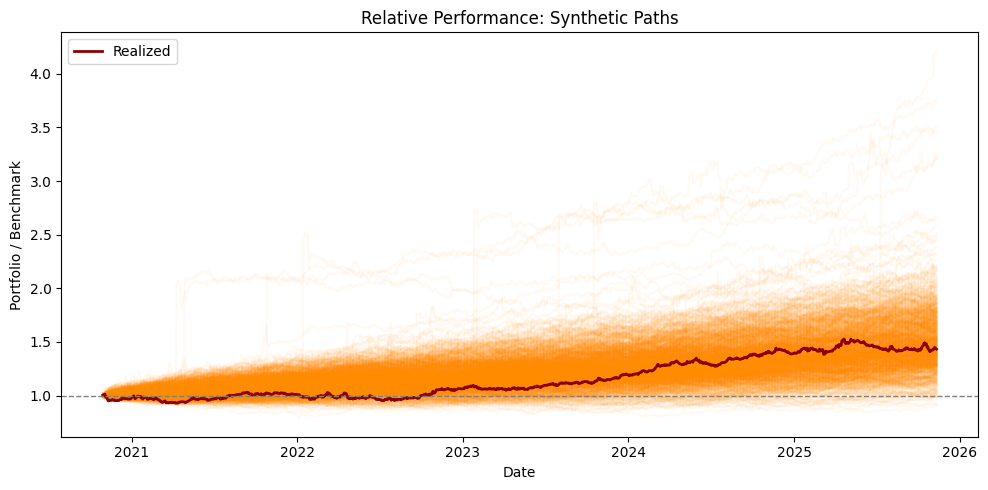

In [18]:
relative_synth = portfolio_synth / benchmark_synth
relative_realized = port_realized / bench_realized

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(oos_dates, relative_synth[:, 1:].T, color='darkorange', alpha=0.05)
ax.plot(oos_dates, relative_realized[1:], color='darkred', lw=2, label='Realized')
ax.axhline(1, color='grey', ls='--', lw=1)

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio / Benchmark')
ax.set_title('Relative Performance: Synthetic Paths')
ax.legend()
plt.tight_layout()
plt.show()

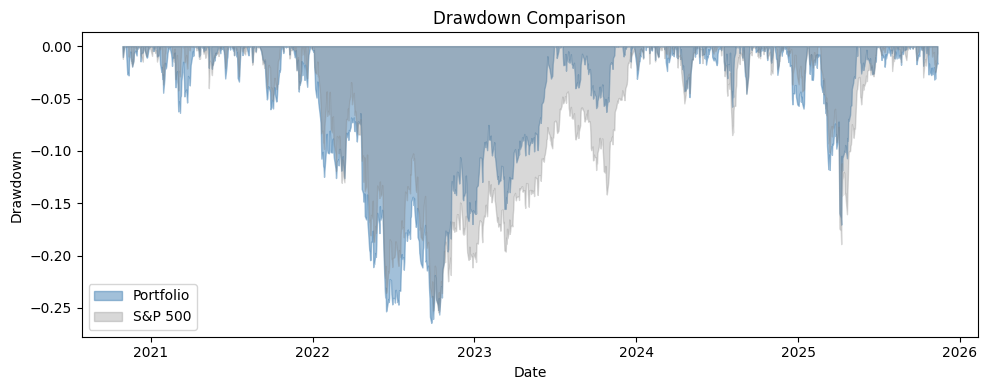

In [19]:
port_cummax = np.maximum.accumulate(port_realized)
bench_cummax = np.maximum.accumulate(bench_realized)
port_dd = (port_realized - port_cummax) / port_cummax
bench_dd = (bench_realized - bench_cummax) / bench_cummax

fig, ax = plt.subplots(figsize=(10, 4))

ax.fill_between(oos_dates, port_dd[1:], 0, alpha=0.5, color='steelblue', label='Portfolio')
ax.fill_between(oos_dates, bench_dd[1:], 0, alpha=0.3, color='grey', label='S&P 500')

ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.set_title('Drawdown Comparison')
ax.legend()
plt.tight_layout()
plt.show()

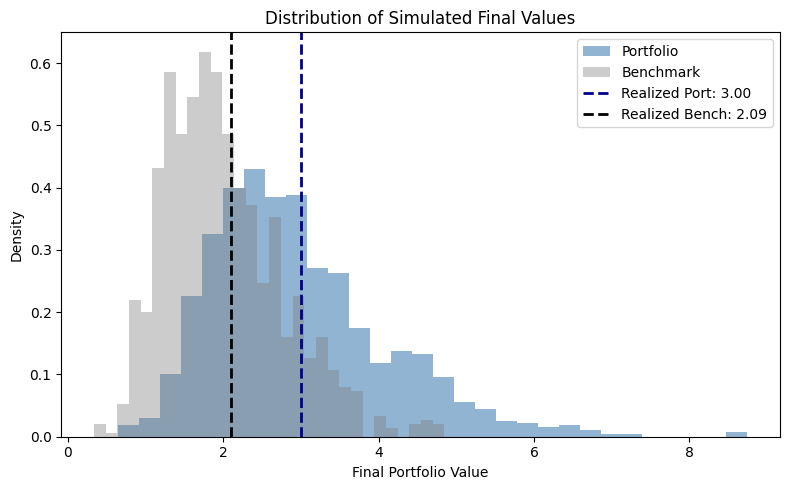

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(portfolio_synth[:, -1], bins=30, alpha=0.6, color='steelblue', label='Portfolio', density=True)
ax.hist(benchmark_synth[:, -1], bins=30, alpha=0.4, color='grey', label='Benchmark', density=True)
ax.axvline(port_realized[-1], color='darkblue', lw=2, ls='--', label=f'Realized Port: {port_realized[-1]:.2f}')
ax.axvline(bench_realized[-1], color='black', lw=2, ls='--', label=f'Realized Bench: {bench_realized[-1]:.2f}')

ax.set_xlabel('Final Portfolio Value')
ax.set_ylabel('Density')
ax.set_title('Distribution of Simulated Final Values')
ax.legend()
plt.tight_layout()
plt.show()